# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

#%matplotlib notebook
%matplotlib inline

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "
/opt/conda_envs/analysis/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
#%%javascript
#var nb = IPython.notebook;
#var kernel = IPython.notebook.kernel;
#var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
#kernel.execute(command);

In [4]:
#print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

In [ ]:
#Test

## Make a directory for saving results

In [5]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "commissioning"

username = "zhangz"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/zhangz/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [6]:
# 50ms dose
uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:16:59', '2016-11-10  21:20:08' #4ms --> 0.4s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:20:09', '2016-11-10  21:23:15' #40ms --> 4s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  21:23:16', '2016-11-10  21:33:52' #0.5s --> 50s , 110 frames

uid_= 'dose_test'
start_time, stop_time = '2016-11-10  21:53:19', '2016-11-10  21:54:37'

# 12.5ms dose
uid_=  'PEO430k_AuNP20nm_25nM_Capillary_RT'
start_time, stop_time = '2016-11-10  22:05:03', '2016-11-10  22:07:37' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-10  22:07:38', '2016-11-10  22:10:18' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-10  22:10:19', '2016-11-10  22:17:59' #0.5s --> 50s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_70C'
start_time, stop_time = '2016-11-11  00:08:08', '2016-11-11  00:10:16 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  00:10:16', '2016-11-11  00:12:31 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  00:12:32', '2016-11-11  00:22:50 ' #0.5s --> 50s , 110 frames

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_85C'
start_time, stop_time = '2016-11-11  01:02:02', '2016-11-11  01:04:21 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  01:04:22', '2016-11-11  01:06:37 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  01:06:37', '2016-11-11  01:17:02 ' #0.5s --> 50s , 110 frames
bad_list = []

uid_=  'PEO430k_AuNP20nm_25nM_Capillary_120C'
start_time, stop_time = '2016-11-11  02:02:36', '2016-11-11  02:04:48 ' #4ms --> 0.4s , 110 frames
start_time, stop_time = '2016-11-11  02:04:49', '2016-11-11  02:07:02 ' #40ms --> 4s , 110 frames
start_time, stop_time = '2016-11-11  02:07:03', '2016-11-11  02:17:24 ' #0.5s --> 50s , 110 frames
bad_list = []


hdrs = db(start_time= start_time, stop_time = stop_time)
hdrs = [x for i,x in enumerate(hdrs) if x['start']['scan_id'] not in bad_list]

print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 10 uids are found
(5594, '74cc1e4e-2703-4e3a-a125-40fffd64c5f2', ['/XF11ID/data/2016/11/11/8636c972-678c-43b0-9071_375'])
(5593, '44d11127-fc20-4624-ba18-c46821a37ba6', ['/XF11ID/data/2016/11/11/1d7c3c0f-9efc-4a49-b537_374'])
(5592, '00583505-e974-49e6-b294-5f7d3bf2d334', ['/XF11ID/data/2016/11/11/266be969-6626-49d4-bb8c_373'])
(5591, 'd5cf86e3-7f60-4a57-942f-2dc9d4ae3f78', ['/XF11ID/data/2016/11/11/7279723c-03cd-4f25-a698_372'])
(5590, 'c2a27d94-e39c-4a57-84d7-0b4e5edd8d07', ['/XF11ID/data/2016/11/11/f94663a5-0e32-467c-a4e1_371'])
(5589, '16442004-0275-4b2d-8353-16e4429a7047', ['/XF11ID/data/2016/11/11/56a47f15-e7fd-4eae-a49e_370'])
(5588, '254411aa-8afb-4d2b-a66b-bc3dcad67dab', ['/XF11ID/data/2016/11/11/da91a5fc-9ae2-4bce-952b_369'])
(5587, '255ec56c-73d3-422f-bba3-d31659989721', ['/XF11ID/data/2016/11/11/888d5c3a-26ab-42c4-bc81_368'])
(5586, '28cb9c5e-a900-4ab5-80e5-c595839bf316', ['/XF11ID/data/2016/11/11/7c53750f-2966-44db-82c5_367'])
(5585, 'd0fce741-de24-42fc-8c34-ccced5

In [7]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/


In [8]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/Average/


# Don't Change these lines below here

In [9]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  image
scan_id, full-uid, data path are:  5585--d0fce741-de24-42fc-8c34-ccced5b62719--/XF11ID/data/2016/11/11/387e226e-f107-4427-8189_366


In [10]:
imgs = load_data( uid, detector , reverse= True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/11/387e226e-f107-4427-8189_366_master.h5


In [11]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [12]:
imgs

Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 110 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [13]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1476.0,
 'beam_center_y': 418.0,
 'count_time': 0.0040000002,
 'detector_distance': 4.8899999,
 'frame_time': 0.0099999998,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly

#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'], md['beam_center_y']  ]   #for 4M
center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.004 sec, Acquisition_period=0.01 sec
Beam center= [418.0, 1476.0]


In [15]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [16]:
setup_pargs

{'Ldet': 4840.0,
 'center': [418.0, 1476.0],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'md': {'Measurement': 'Measurement',
  'beam_center_x': 1476.0,
  'beam_center_y': 418.0,
  'count_time': 0.0040000002,
  'detector_distance': 4.8899999,
  'frame_time': 0.0099999998,
  'incident_wavelength': 1.2848103,
  'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
  'sample': 'sample',
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05},
 'path': '/XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/Average/',
 'timeperframe': 0.0099999998,
 'uid': 'PEO430k_AuNP20nm_25nM_Capillary_120C'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [17]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov10_4M_mask.npy'

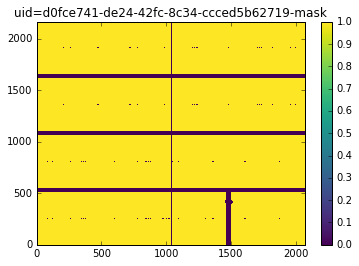

In [18]:
mask = load_mask(mask_path, mask_name, plot_ =  True, reverse=True, image_name = 'uid=%s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [19]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = None #NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [20]:
imgsa = apply_mask( imgs, mask )

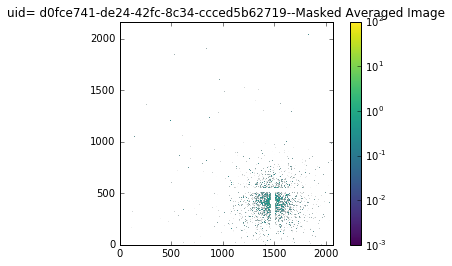

In [21]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

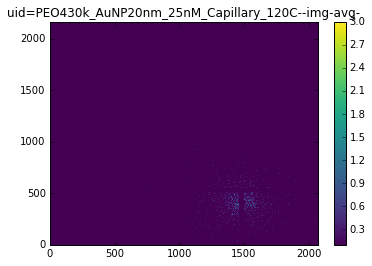

In [22]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


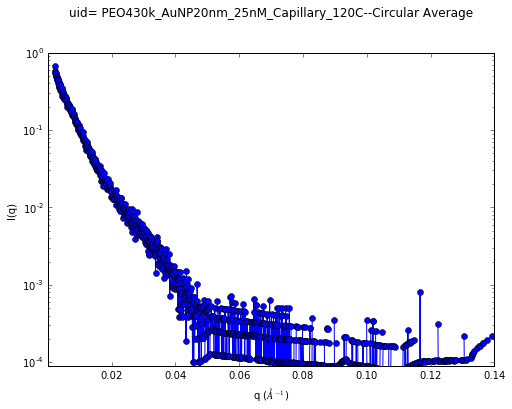

In [23]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e0], save=True)



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [24]:
uniform = True

### Define a non-uniform distributed rings by giving edges

In [25]:
if not uniform:
    #width = 4  # in pixel
    width = 0.001    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.0065,0.0117,0.021,0.0336,0.044, 0.057] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [26]:
if uniform:
    inner_radius= 0.0045
    outer_radius = 0.062
    width = 0.0035
    num_rings = 10
    edges = None

In [27]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [28]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [29]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

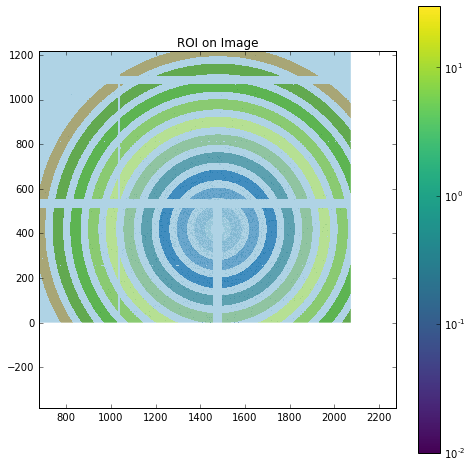

In [30]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=800, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

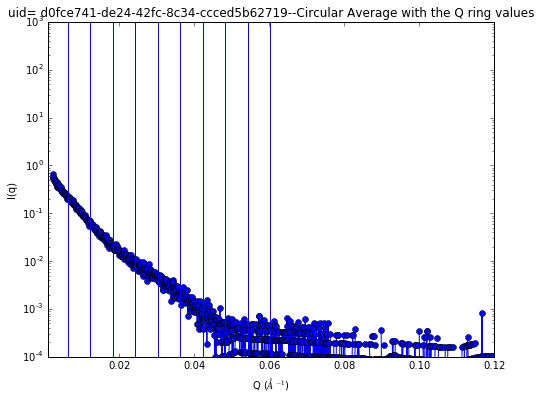

In [31]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-4, 1e3],        save=True, path=data_dir)

# Do loop here

In [33]:
run_num = 1
sub_num =  len(uids) //run_num
print( run_num, sub_num)

1 10


In [34]:
data_dir

'/XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/'

Get each frame intensity:   0%|          | 0/110 [00:00<?, ?it/s]

The 0--th uid to be analyzed is : d0fce741-de24-42fc-8c34-ccced5b62719
hdf5 path = /XF11ID/data/2016/11/11/387e226e-f107-4427-8189_366_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_d0fce741-de24-42fc-8c34-ccced5b62719.cmp.


Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 3209.51it/s]


No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  8.15it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/d0fce741-de24-42fc-8c34-ccced5b62719/ with filename as uid=d0fce741-de24-42fc-8c34-ccced5b62719--g2.csv


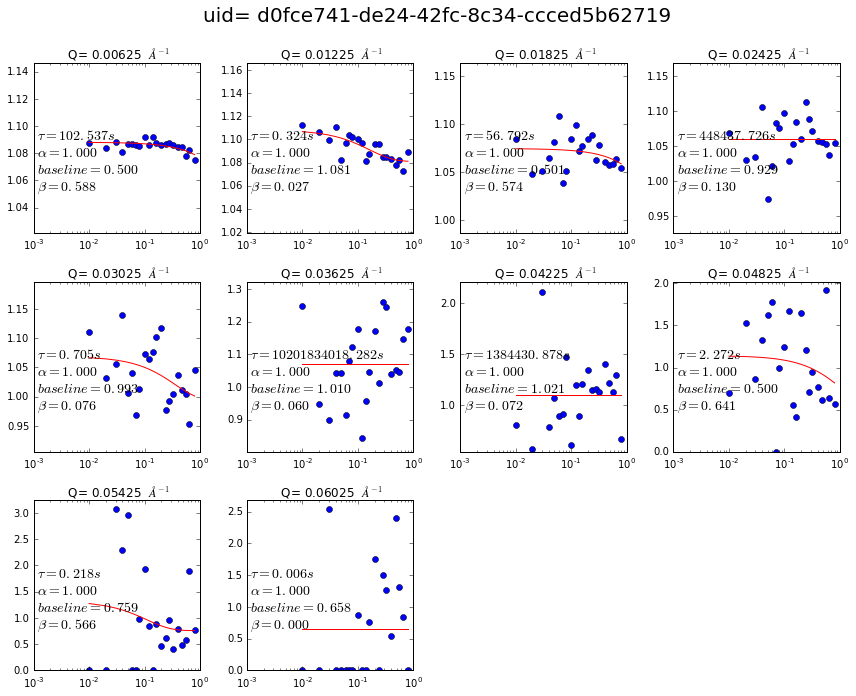

The fitted diffusion coefficient D0 is:  1.983e+04   A^2S-1


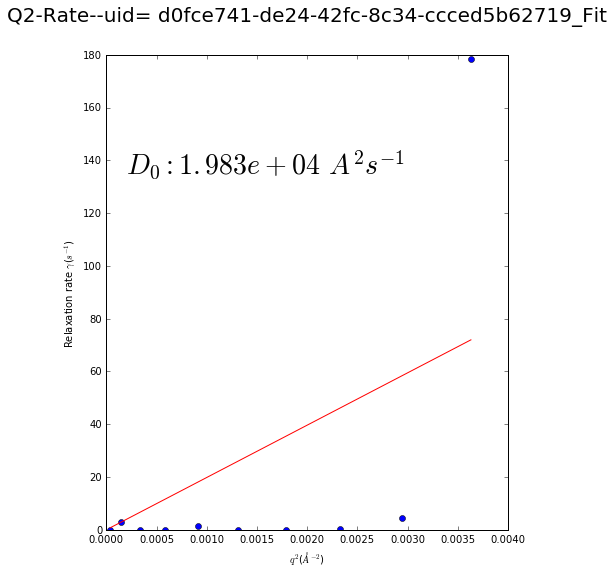

Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 9021.60it/s]

****************************************

The 1--th uid to be analyzed is : 28cb9c5e-a900-4ab5-80e5-c595839bf316
hdf5 path = /XF11ID/data/2016/11/11/7c53750f-2966-44db-82c5_367_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_28cb9c5e-a900-4ab5-80e5-c595839bf316.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 


In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  6.16it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/28cb9c5e-a900-4ab5-80e5-c595839bf316/ with filename as uid=28cb9c5e-a900-4ab5-80e5-c595839bf316--g2.csv


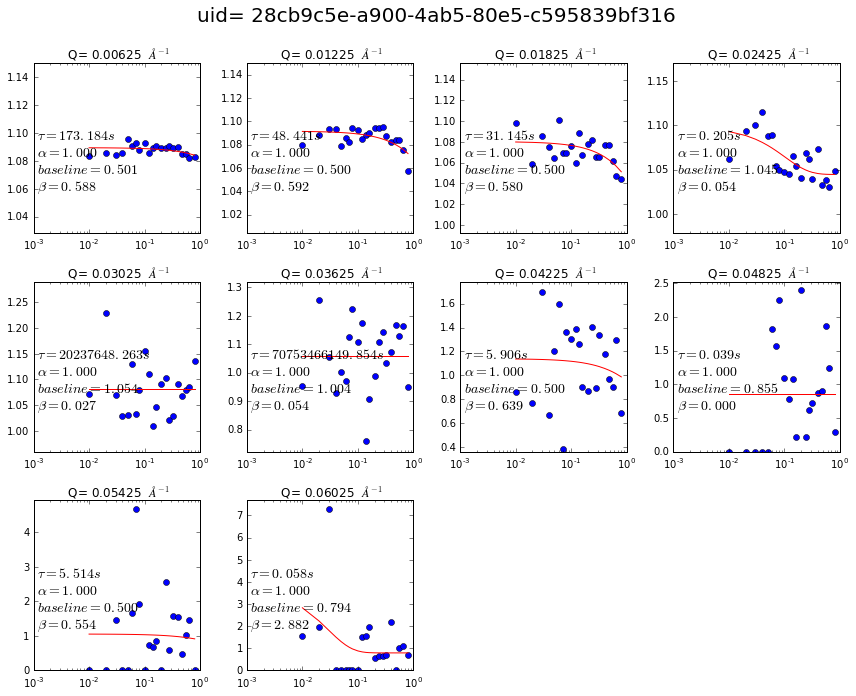

The fitted diffusion coefficient D0 is:  3.780e+03   A^2S-1


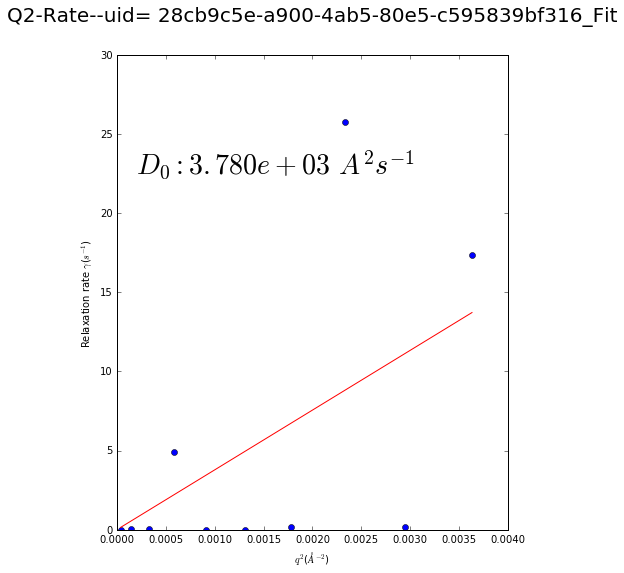

Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 9637.04it/s]

****************************************

The 2--th uid to be analyzed is : 255ec56c-73d3-422f-bba3-d31659989721
hdf5 path = /XF11ID/data/2016/11/11/888d5c3a-26ab-42c4-bc81_368_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_255ec56c-73d3-422f-bba3-d31659989721.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 


In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  7.99it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/255ec56c-73d3-422f-bba3-d31659989721/ with filename as uid=255ec56c-73d3-422f-bba3-d31659989721--g2.csv


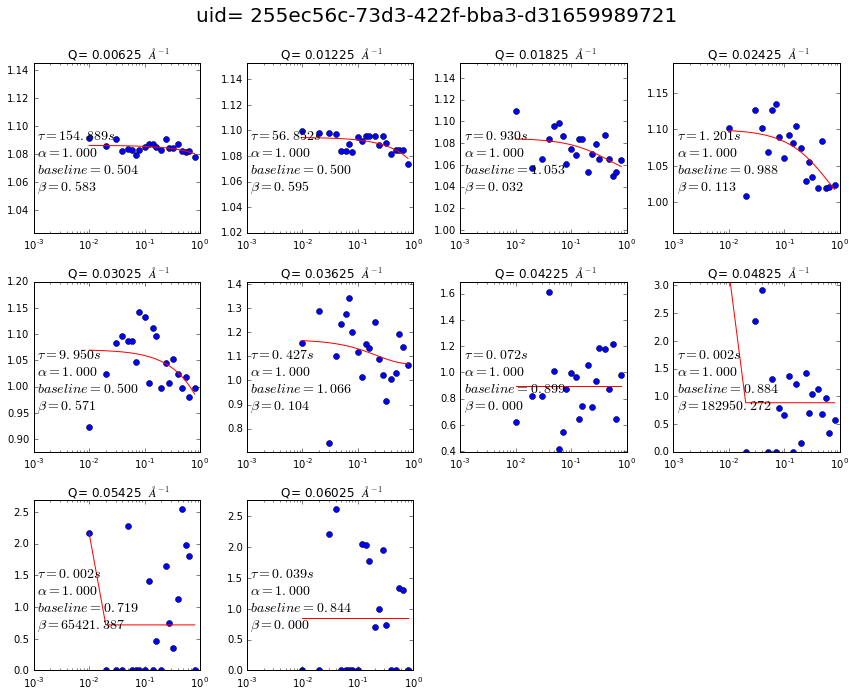

The fitted diffusion coefficient D0 is:  8.984e+04   A^2S-1


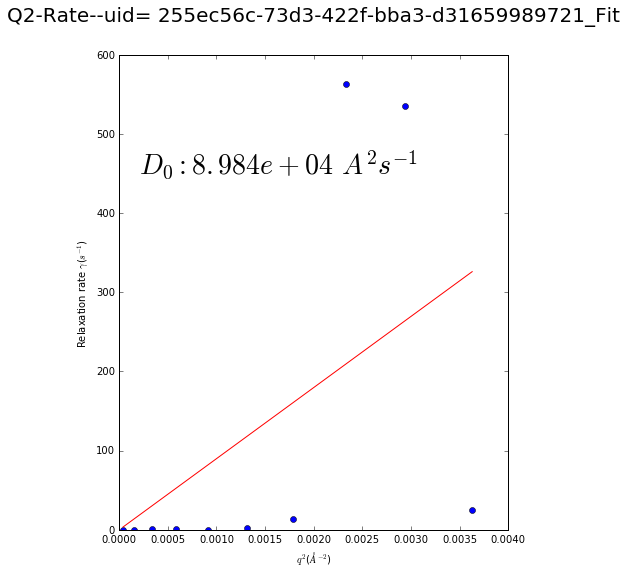

Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 6712.06it/s]

****************************************

The 3--th uid to be analyzed is : 254411aa-8afb-4d2b-a66b-bc3dcad67dab
hdf5 path = /XF11ID/data/2016/11/11/da91a5fc-9ae2-4bce-952b_369_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_254411aa-8afb-4d2b-a66b-bc3dcad67dab.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 


In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  8.13it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/254411aa-8afb-4d2b-a66b-bc3dcad67dab/ with filename as uid=254411aa-8afb-4d2b-a66b-bc3dcad67dab--g2.csv


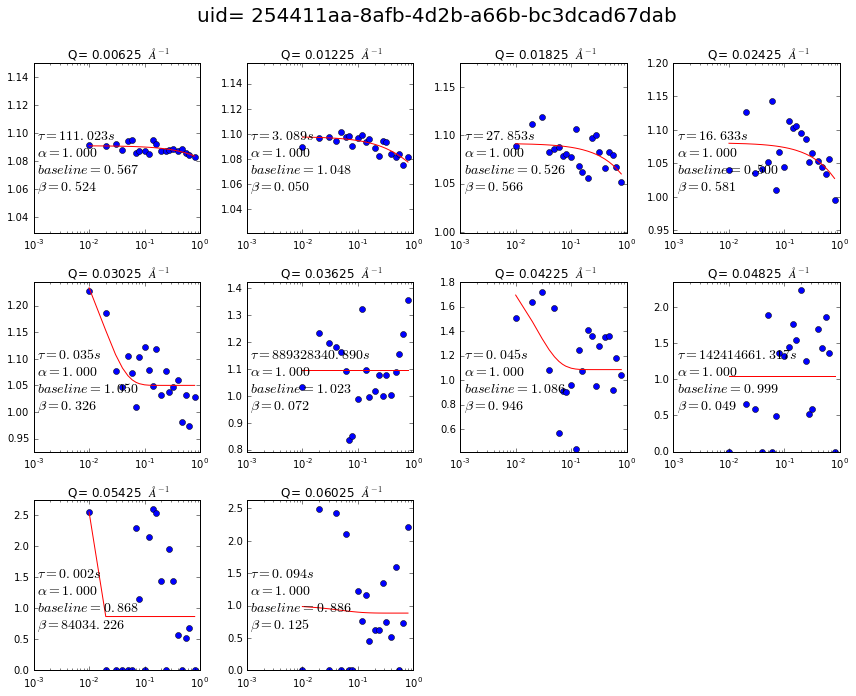

The fitted diffusion coefficient D0 is:  5.065e+04   A^2S-1


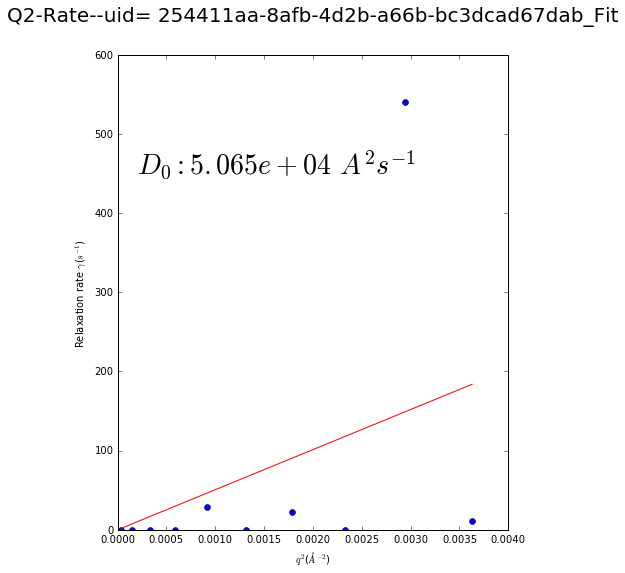

Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 9161.87it/s]

****************************************

The 4--th uid to be analyzed is : 16442004-0275-4b2d-8353-16e4429a7047
hdf5 path = /XF11ID/data/2016/11/11/56a47f15-e7fd-4eae-a49e_370_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_16442004-0275-4b2d-8353-16e4429a7047.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 


In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  8.17it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/16442004-0275-4b2d-8353-16e4429a7047/ with filename as uid=16442004-0275-4b2d-8353-16e4429a7047--g2.csv


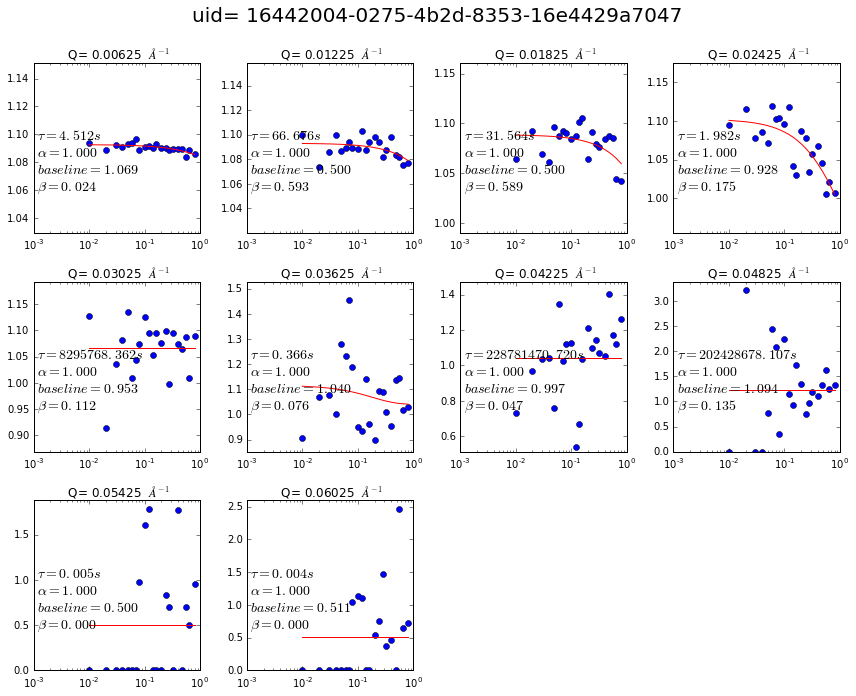

The fitted diffusion coefficient D0 is:  4.528e+04   A^2S-1


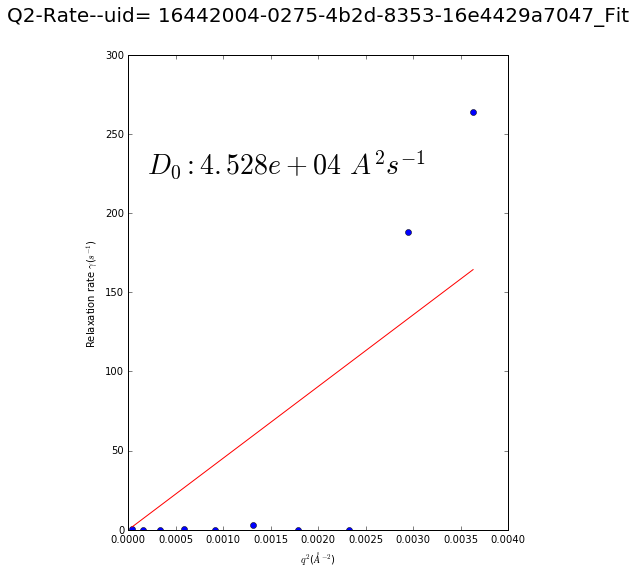

Get each frame intensity: 100%|██████████| 110/110 [00:00<00:00, 9692.11it/s]

****************************************

The 5--th uid to be analyzed is : c2a27d94-e39c-4a57-84d7-0b4e5edd8d07
hdf5 path = /XF11ID/data/2016/11/11/f94663a5-0e32-467c-a4e1_371_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_c2a27d94-e39c-4a57-84d7-0b4e5edd8d07.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 



  0%|          | 0/100 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:11<00:00,  8.08it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/c2a27d94-e39c-4a57-84d7-0b4e5edd8d07/ with filename as uid=c2a27d94-e39c-4a57-84d7-0b4e5edd8d07--g2.csv


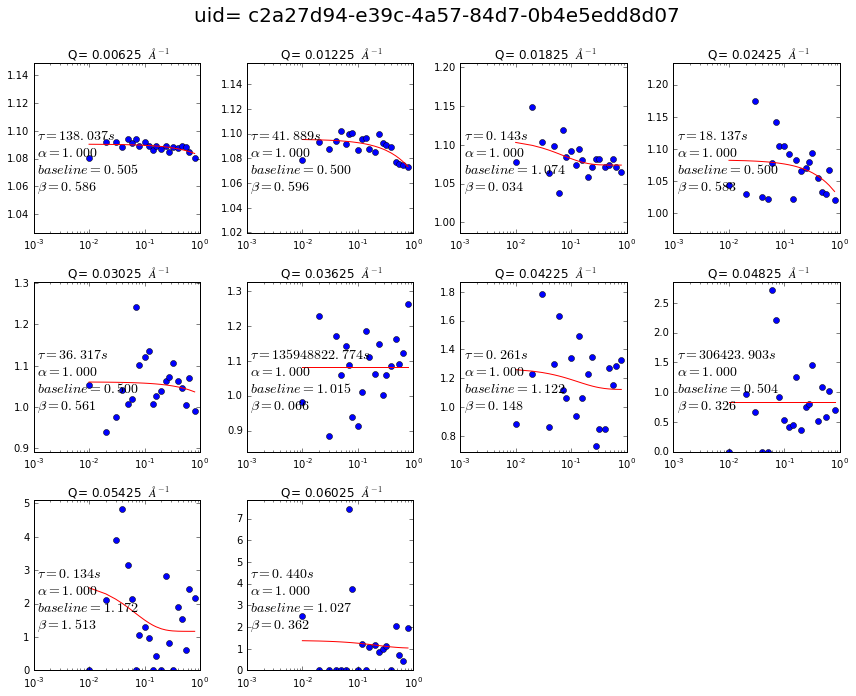

The fitted diffusion coefficient D0 is:  1.179e+03   A^2S-1


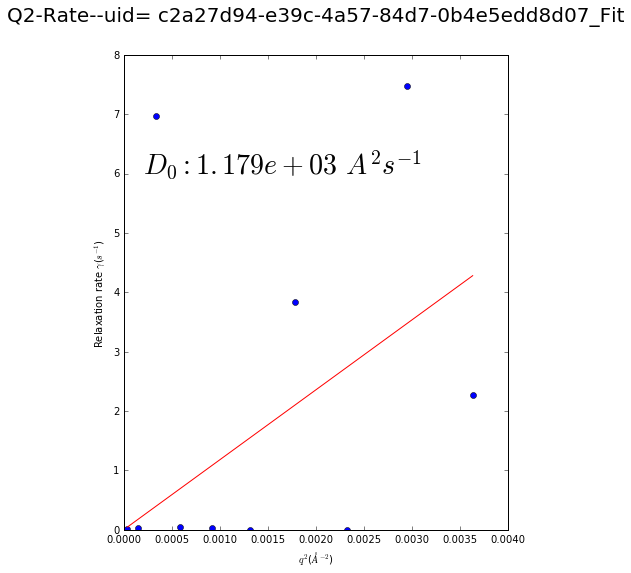

Get each frame intensity: 100%|██████████| 100/100 [00:00<00:00, 8896.60it/s]

****************************************

The 6--th uid to be analyzed is : d5cf86e3-7f60-4a57-942f-2dc9d4ae3f78
hdf5 path = /XF11ID/data/2016/11/11/7279723c-03cd-4f25-a698_372_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_d5cf86e3-7f60-4a57-942f-2dc9d4ae3f78.cmp.
No bad frames are involved.
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 



  0%|          | 0/90 [00:00<?, ?it/s]

In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:10<00:00,  8.37it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/d5cf86e3-7f60-4a57-942f-2dc9d4ae3f78/ with filename as uid=d5cf86e3-7f60-4a57-942f-2dc9d4ae3f78--g2.csv


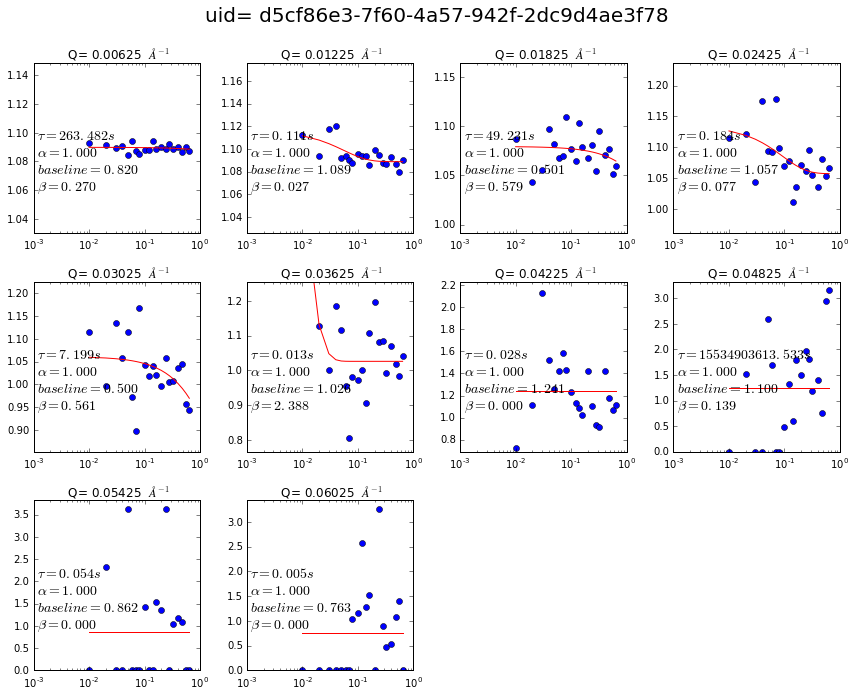

The fitted diffusion coefficient D0 is:  2.690e+04   A^2S-1


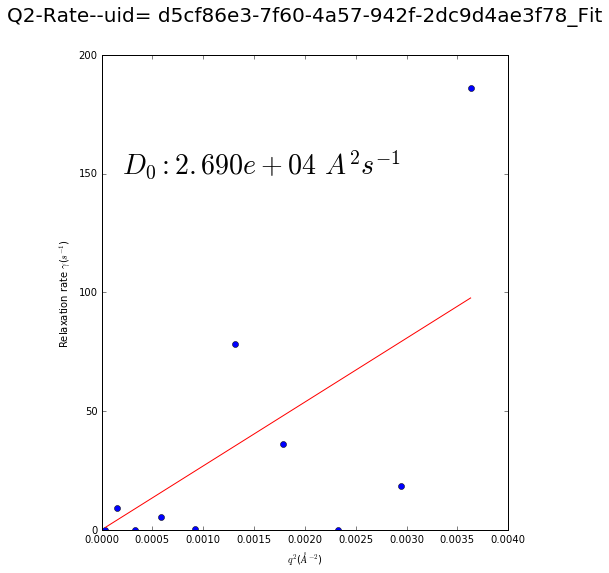

****************************************

The 7--th uid to be analyzed is : 00583505-e974-49e6-b294-5f7d3bf2d334
hdf5 path = /XF11ID/data/2016/11/11/266be969-6626-49d4-bb8c_373_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_00583505-e974-49e6-b294-5f7d3bf2d334.cmp.
Using a multiprocess to compress the data.
It will create 1 temporary files for parallel compression.


100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


No bad frames are involved.
Combining the seperated compressed files together...
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 100 
In this g2 calculation, the buf and lev number are: 8--5--
90 frames will be processed...


100%|██████████| 90/90 [00:10<00:00,  7.06it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/00583505-e974-49e6-b294-5f7d3bf2d334/ with filename as uid=00583505-e974-49e6-b294-5f7d3bf2d334--g2.csv


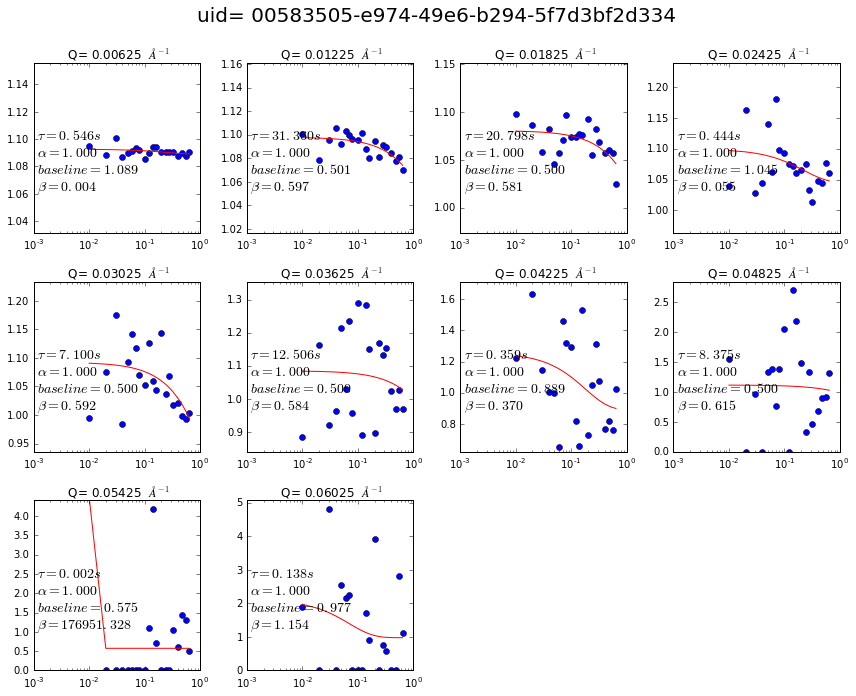

The fitted diffusion coefficient D0 is:  4.806e+04   A^2S-1


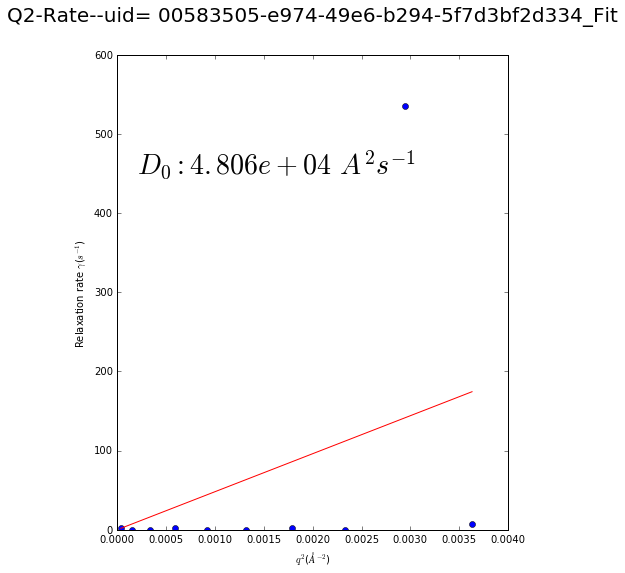

****************************************

The 8--th uid to be analyzed is : 44d11127-fc20-4624-ba18-c46821a37ba6
hdf5 path = /XF11ID/data/2016/11/11/1d7c3c0f-9efc-4a49-b537_374_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_44d11127-fc20-4624-ba18-c46821a37ba6.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:05<00:00,  3.13s/it]


No bad frames are involved.
Combining the seperated compressed files together...
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/44d11127-fc20-4624-ba18-c46821a37ba6/ with filename as uid=44d11127-fc20-4624-ba18-c46821a37ba6--g2.csv


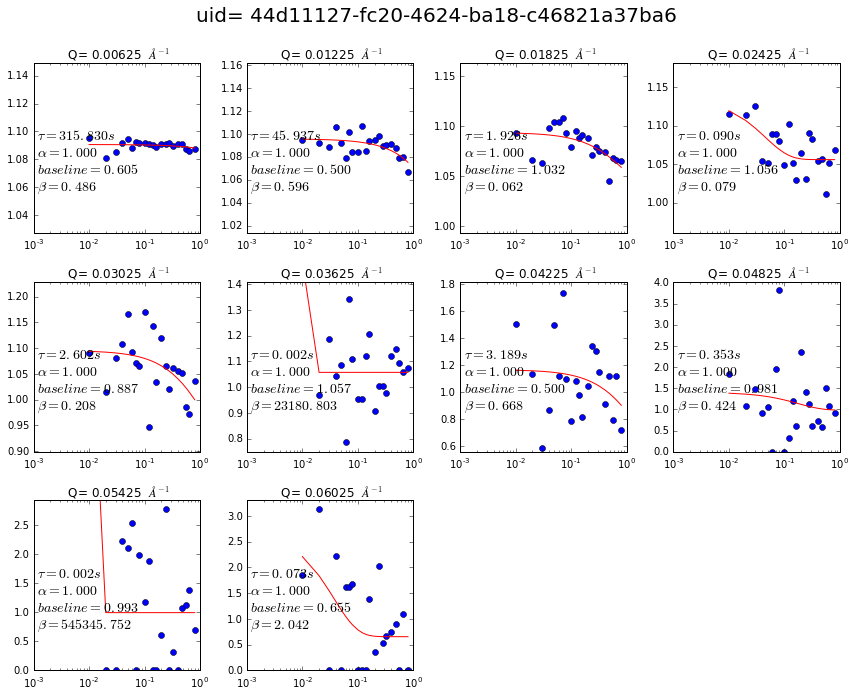

The fitted diffusion coefficient D0 is:  7.363e+04   A^2S-1


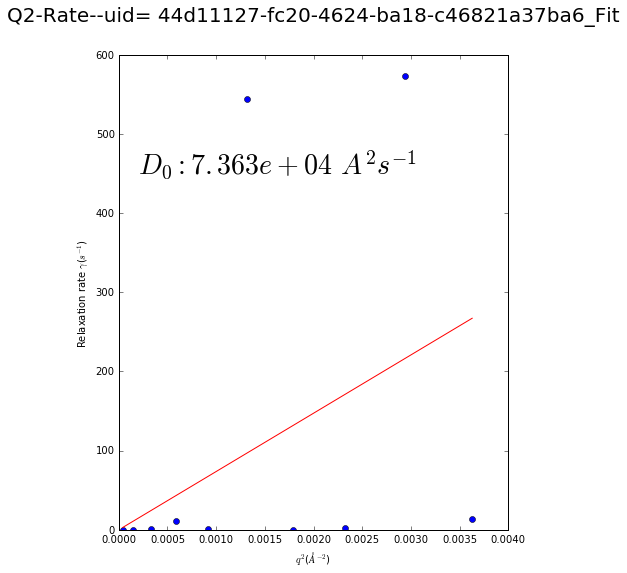

****************************************

The 9--th uid to be analyzed is : 74cc1e4e-2703-4e3a-a125-40fffd64c5f2
hdf5 path = /XF11ID/data/2016/11/11/8636c972-678c-43b0-9071_375_master.h5
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_74cc1e4e-2703-4e3a-a125-40fffd64c5f2.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image
It will create 2 temporary files for parallel compression.


100%|██████████| 2/2 [00:06<00:00,  3.55s/it]


No bad frames are involved.
Combining the seperated compressed files together...
first sample 120C
With compression, the good_start frame number is: 10 
The good_end frame number is: 110 
In this g2 calculation, the buf and lev number are: 8--5--
100 frames will be processed...


100%|██████████| 100/100 [00:12<00:00,  8.09it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/74cc1e4e-2703-4e3a-a125-40fffd64c5f2/ with filename as uid=74cc1e4e-2703-4e3a-a125-40fffd64c5f2--g2.csv


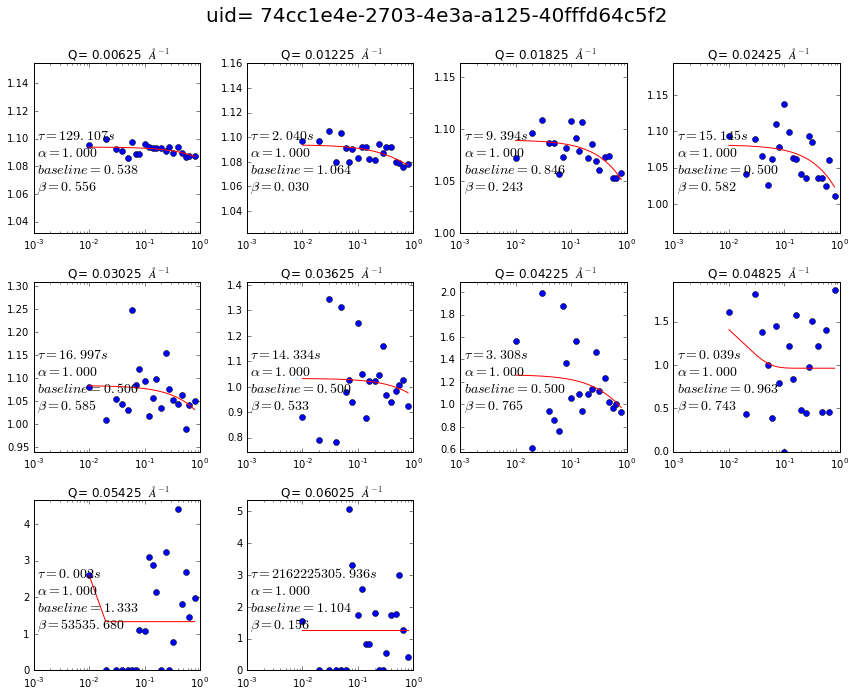

The fitted diffusion coefficient D0 is:  4.860e+04   A^2S-1


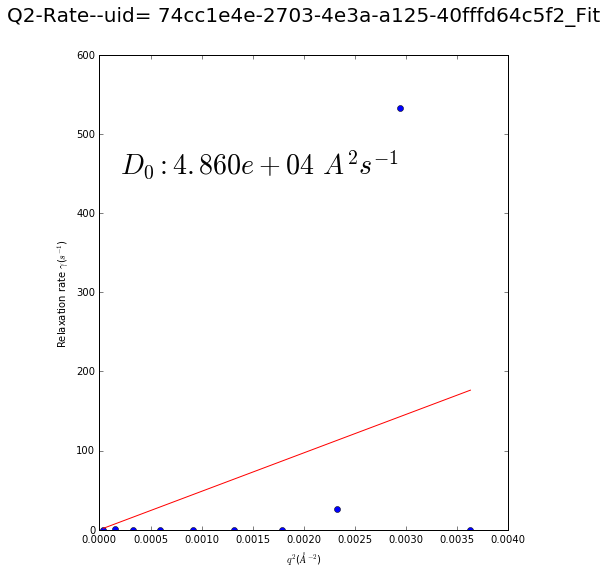

****************************************



In [35]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, 
                                    fit= True, force_compress= False,  compress= True  )


## Create PDF report for each uid

In [36]:
useful_uids

{1: {1: 'd0fce741-de24-42fc-8c34-ccced5b62719',
  2: '28cb9c5e-a900-4ab5-80e5-c595839bf316',
  3: '255ec56c-73d3-422f-bba3-d31659989721',
  4: '254411aa-8afb-4d2b-a66b-bc3dcad67dab',
  5: '16442004-0275-4b2d-8353-16e4429a7047',
  6: 'c2a27d94-e39c-4a57-84d7-0b4e5edd8d07',
  7: 'd5cf86e3-7f60-4a57-942f-2dc9d4ae3f78',
  8: '00583505-e974-49e6-b294-5f7d3bf2d334',
  9: '44d11127-fc20-4624-ba18-c46821a37ba6',
  10: '74cc1e4e-2703-4e3a-a125-40fffd64c5f2'}}

In [37]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

* Create multi PDF report for each uid

In [38]:
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir, append_name='_1' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/XPCS_Analysis_Report_for_uid=d0fce741-de24-42fc-8c34-ccced5b62719_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/XPCS_Analysis_Report_for_uid=28cb9c5e-a900-4ab5-80e5-c595839bf316_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/XPCS_Analysis_Report_for_uid=255ec56c-73d3-422f-bba3-d31659989721_1.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/XPCS_Analysis

### Attach each g2 result to the corresponding olog entry

In [39]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [40]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [41]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s_1.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
     
    

## Create one PDF including all uids

In [42]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/XPCS_Analysis_Report_for_uid=PEO430k_AuNP20nm_25nM_Capillary_120C.pdf
****************************************


# Do average Here

In [43]:
list( g2s[1].keys() )

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [44]:
bad_uids =[  ]

In [45]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            if sub_key not in bad_uids:
                g2s_average[key] +=  g2s[key][sub_key]
                i +=1
                print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
                #print( 'sub= %s,Doing average here'%sub_key)
            else:
                print( 'sub= %s,Can not Doing average here'%sub_key)
                
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
Run= 1--sub_run= 5-- pass
Run= 1--sub_run= 6-- pass
sub= 7,Can not Doing average here
sub= 8,Can not Doing average here
Run= 1--sub_run= 9-- pass
Run= 1--sub_run= 10-- pass


# Save Data

In [46]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


The correlation function is saved in /XF11ID/analysis/2016_3/zhangz/Results/PEO430k_AuNP20nm_25nM_Capillary_120C/Average/ with filename as uid=PEO430k_AuNP20nm_25nM_Capillary_120C@run--1--g2.csv


# Plot All the g2 Data

In [47]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Averaged Data

/opt/conda_envs/analysis/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


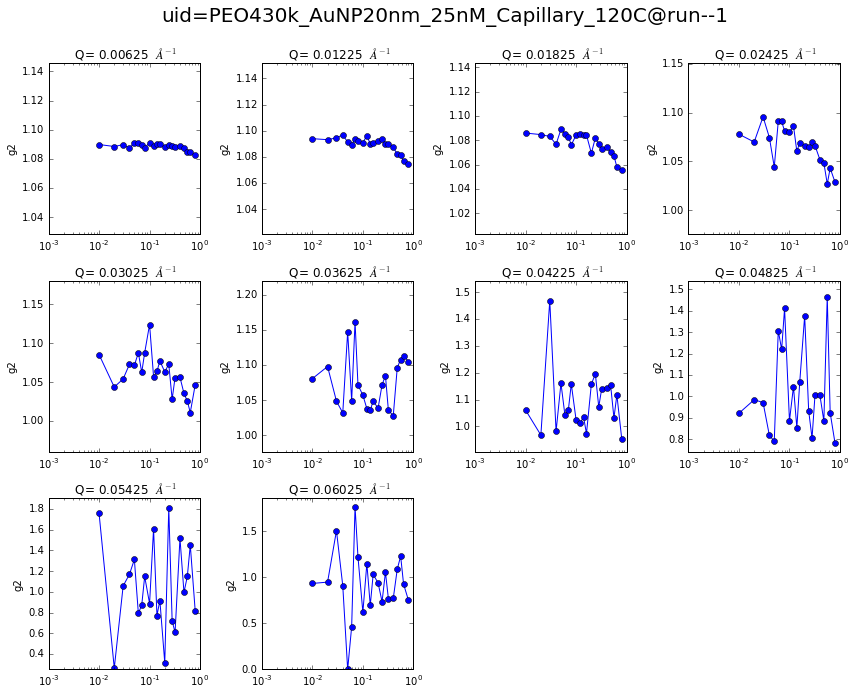

In [48]:
if True:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [49]:
fit = True

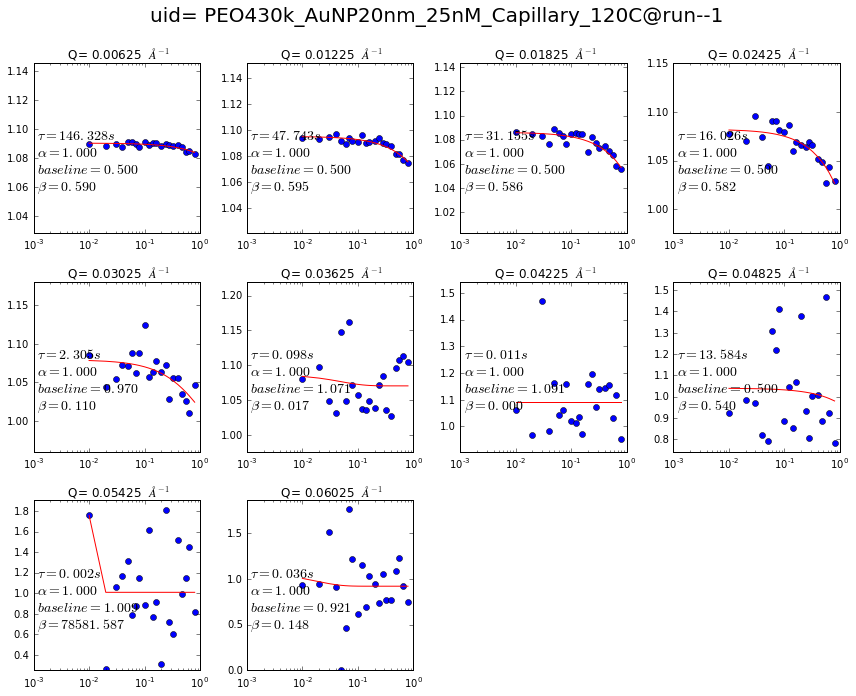

The fitted diffusion coefficient D0 is:  5.904e+04   A^2S-1


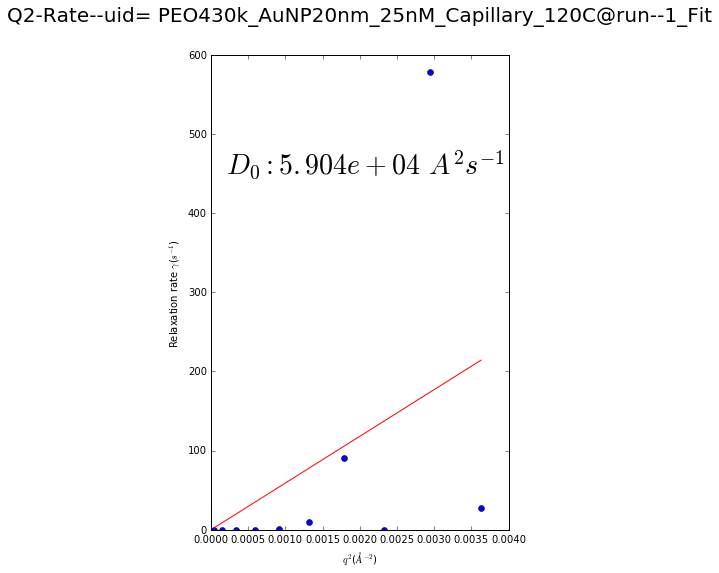

In [50]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.08,'alpha':1.0,'relaxation_rate':0.01})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center, fit_result['rate'], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [51]:
create_report = True

In [52]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [53]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_3/zhangz/Results/XPCS_Analysis_Report_for_uid=PEO430k_AuNP20nm_25nM_Capillary_120C-average.pdf


In [54]:
uid_

'PEO430k_AuNP20nm_25nM_Capillary_120C'

In [55]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/zhangz/Results/XPCS_Analysis_Report_for_uid=PEO430k_AuNP20nm_25nM_Capillary_120C-average.pdf
****************************************


# The End!

In [56]:
last_uid_num = len( useful_uids[1] )

In [57]:
uid_last = useful_uids[1][    last_uid_num     ]
print( uid_last )

74cc1e4e-2703-4e3a-a125-40fffd64c5f2


In [58]:
#uid_last = useful_uids[1][-1]

In [59]:
c.filename

'/XF11ID/analysis/2016_3/zhangz/Results/XPCS_Analysis_Report_for_uid=PEO430k_AuNP20nm_25nM_Capillary_120C-average.pdf'

In [60]:
#uid_ = uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )